--- 1. Generating Simulated Hospital Readmission Data ---
Simulated dataset created with 2000 rows and 14 columns.
First 5 rows of the dataset:
   patient_id  age  gender         ethnicity admission_type  num_diagnoses  \
0           1   88  Female         Caucasian       Elective              9   
1           2   84  Female             Asian         Urgent              4   
2           3   69    Male             Asian      Emergency              8   
3           4   41    Male         Caucasian         Urgent              7   
4           5   78  Female  African American         Urgent              1   

   num_medications  length_of_stay_days  prior_admissions_last_year  \
0                6                    2                           3   
1               18                   15                           3   
2                2                   16                           4   
3               10                   26                           2   
4               13              

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:36:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training complete.

--- 4. Evaluation ---

--- Evaluation on Validation Set ---
Classification Report (Validation Set):
                precision    recall  f1-score   support

No Readmission       0.71      0.90      0.79       211
   Readmission       0.33      0.12      0.18        89

      accuracy                           0.67       300
     macro avg       0.52      0.51      0.49       300
  weighted avg       0.60      0.67      0.61       300

F1-Score (Validation Set): 0.1803
AUC-ROC (Validation Set): 0.5429

--- Evaluation on Test Set (Final Assessment) ---
F1-Score (Test Set): 0.2241
AUC-ROC (Test Set): 0.5341

Classification Report (Test Set):
                precision    recall  f1-score   support

No Readmission       0.72      0.93      0.81       212
   Readmission       0.46      0.15      0.22        88

      accuracy                           0.70       300
     macro avg       0.59      0.54      0.52       300
  weighted avg       0.65      0.70      0.64

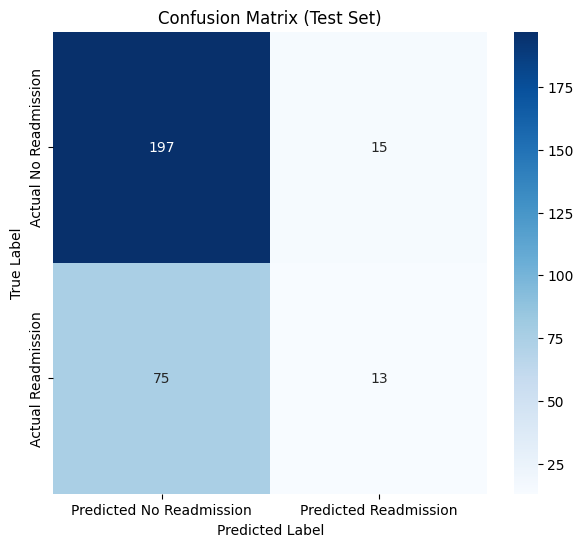

<Figure size 800x700 with 0 Axes>

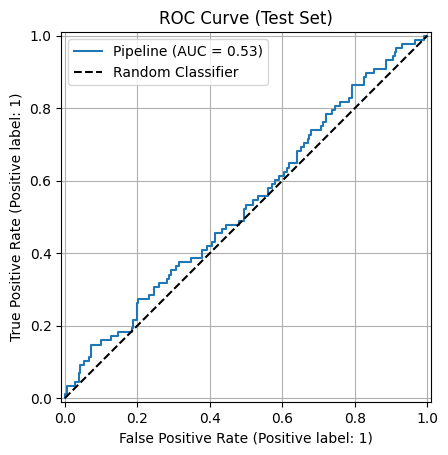


--- End of Hospital Readmission Analysis Script ---
This script provides a complete demonstration of the AI development workflow for predicting patient readmission risk.
The generated plots (Confusion Matrix, ROC Curve) will appear in your output.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 1. Data Generation (Simulated Hospital Readmission Dataset) ---
# This section creates a synthetic dataset for predicting patient readmission risk.
# In a real hospital scenario, this data would come from Electronic Health Records (EHRs),
# billing systems, and other clinical databases.

print("--- 1. Generating Simulated Hospital Readmission Data ---")

np.random.seed(43) # for reproducibility of numerical data
random.seed(43)   # for reproducibility of categorical choices

num_patients = 2000 # Define the number of patients in the dataset

# Simulate patient demographic and clinical data
genders = ['Male', 'Female']
ethnicities = ['Caucasian', 'African American', 'Asian', 'Hispanic', 'Other']
admission_types = ['Emergency', 'Elective', 'Urgent']
discharge_dispositions = ['Home', 'Skilled Nursing Facility', 'Rehabilitation', 'Hospice', 'Other']
insurance_types = ['Private', 'Medicare', 'Medicaid', 'None']

data = {
    'patient_id': range(1, num_patients + 1), # Unique identifier for each patient
    'age': np.random.randint(20, 95, num_patients), # Age of the patient
    'gender': np.random.choice(genders, num_patients, p=[0.49, 0.51]),
    'ethnicity': np.random.choice(ethnicities, num_patients, p=[0.5, 0.2, 0.15, 0.1, 0.05]),
    'admission_type': np.random.choice(admission_types, num_patients, p=[0.6, 0.25, 0.15]),
    'num_diagnoses': np.random.randint(1, 10, num_patients), # Number of unique diagnoses
    'num_medications': np.random.randint(1, 20, num_patients), # Number of prescribed medications
    'length_of_stay_days': np.random.randint(1, 30, num_patients), # Days patient stayed in hospital
    'prior_admissions_last_year': np.random.randint(0, 5, num_patients), # Number of prior admissions in last year
    'comorbidity_score': np.random.normal(5, 3, num_patients).clip(0, 15).astype(int), # Simulated comorbidity index
    'discharge_disposition': np.random.choice(discharge_dispositions, num_patients, p=[0.7, 0.15, 0.08, 0.05, 0.02]),
    'insurance_type': np.random.choice(insurance_types, num_patients, p=[0.4, 0.3, 0.2, 0.1]),
    'lab_value_A': np.random.normal(100, 20, num_patients) # Example lab value
}

# Introduce some missing values for 'lab_value_A' (e.g., 8% missing)
data['lab_value_A'][np.random.choice(num_patients, int(num_patients * 0.08), replace=False)] = np.nan

# Simulate target variable: readmission_30_days (1 for readmitted, 0 for not)
# Make readmission correlated with some features to simulate real-world patterns
readmission_prob = (
    0.08 # Base probability
    + (data['age'] > 70) * 0.07 # Older patients higher risk
    + (data['num_diagnoses'] > 5) * 0.05 # More diagnoses higher risk
    + (data['length_of_stay_days'] > 10) * 0.06 # Longer stay higher risk
    + (data['prior_admissions_last_year'] > 0) * 0.1 # Any prior admission increases risk
    + (data['comorbidity_score'] > 7) * 0.08 # Higher comorbidity higher risk
    + (data['discharge_disposition'] != 'Home') * 0.12 # Not discharged home higher risk
    + (data['insurance_type'] == 'Medicaid') * 0.04 # Medicaid patients slightly higher risk
    + (data['lab_value_A'] < 80) * 0.05 # Low lab value A increases risk
)
readmission_prob = np.clip(readmission_prob, 0.05, 0.4) # Clip probabilities to a reasonable range

data['readmission_30_days'] = (np.random.rand(num_patients) < readmission_prob).astype(int)

df = pd.DataFrame(data)

print(f"Simulated dataset created with {df.shape[0]} rows and {df.shape[1]} columns.")
print("First 5 rows of the dataset:")
print(df.head())
print("\nMissing values before preprocessing:")
print(df.isnull().sum())
print(f"\n30-day Readmission Rate: {df['readmission_30_days'].mean():.2%}")


# --- 2. Data Preprocessing & Feature Engineering ---
# This section implements the preprocessing steps outlined in the assignment:
# - Handling missing data
# - Feature Engineering
# - Normalization/Scaling
# - Encoding categorical features

print("\n--- 2. Data Preprocessing & Feature Engineering ---")

# Define numerical and categorical features based on the dataset
numerical_features = [
    'age', 'num_diagnoses', 'num_medications', 'length_of_stay_days',
    'prior_admissions_last_year', 'comorbidity_score', 'lab_value_A'
]
categorical_features = [
    'gender', 'ethnicity', 'admission_type', 'discharge_disposition', 'insurance_type'
]

# --- Feature Engineering ---
# As proposed in the assignment, create a new composite feature: Medication Complexity Score.
# This might indicate how complex a patient's medication regimen is relative to their diagnoses.
# Handle division by zero for num_diagnoses.
df['medication_complexity_score'] = df.apply(
    lambda row: row['num_medications'] / row['num_diagnoses'] if row['num_diagnoses'] > 0 else 0,
    axis=1
)

# Add the newly engineered feature to the list of numerical features
numerical_features.append('medication_complexity_score')

# Separate features (X) and target variable (y)
X = df.drop(['patient_id', 'readmission_30_days'], axis=1)
y = df['readmission_30_days']

# Create preprocessing pipelines for numerical and categorical features
# Numerical pipeline: Impute missing values with mean, then apply StandardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Handles missing data
    ('scaler', StandardScaler()) # Normalization/Scaling
])

# Categorical pipeline: One-hot encode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Encoding categorical features
])

# Combine preprocessing steps using ColumnTransformer
# This applies the correct transformer to the correct set of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipelines defined, including feature engineering for 'medication_complexity_score'.")


# --- 3. Model Development ---
# This section covers splitting the data and training the chosen model (XGBoost).

print("\n--- 3. Model Development ---")

# Split data into training, validation, and test sets
# A common split is 70% train, 15% validation, 15% test.
# stratify=y ensures that the proportion of readmission cases is maintained in each split,
# which is important for imbalanced datasets common in healthcare.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Data split into: Training ({X_train.shape[0]} samples), Validation ({X_val.shape[0]} samples), Test ({X_test.shape[0]} samples).")

# Choose a model: XGBoost Classifier
# Justification: XGBoost is a powerful ensemble method known for high accuracy on tabular data,
# handles various data types, and provides feature importance. Its robustness makes it suitable
# for critical applications like healthcare.
# Hyperparameters: n_estimators and learning_rate are two key hyperparameters to tune.
# - n_estimators: Controls the number of boosting rounds/trees. Tuning helps prevent under/overfitting.
# - learning_rate: Controls the step size at each iteration. Smaller values lead to more robust models.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', XGBClassifier(objective='binary:logistic',
                                                              eval_metric='logloss', # Evaluation metric for training
                                                              use_label_encoder=False, # Suppress deprecation warning
                                                              random_state=42,
                                                              n_estimators=200, # Example initial value for tuning
                                                              learning_rate=0.05 # Example initial value for tuning
                                                              ))])

# Train the model using the training data
print("\nTraining the XGBoost model on the training set...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")


# --- 4. Evaluation ---
# This section evaluates the trained model using relevant metrics and visualizations.

print("\n--- 4. Evaluation ---")

# Evaluate on the Validation Set first (as if for hyperparameter tuning)
print("\n--- Evaluation on Validation Set ---")
y_val_pred = model_pipeline.predict(X_val)
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1] # Probability of the positive class (readmission)

print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred, target_names=['No Readmission', 'Readmission']))

f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"F1-Score (Validation Set): {f1_val:.4f}")
print(f"AUC-ROC (Validation Set): {roc_auc_val:.4f}")


# Evaluate on the Unseen Test Set (Final Model Performance Assessment)
print("\n--- Evaluation on Test Set (Final Assessment) ---")
y_test_pred = model_pipeline.predict(X_test)
y_test_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (readmission)

# Evaluation Metrics:
# 1. F1-Score: Harmonic mean of Precision and Recall. Highly relevant for imbalanced datasets
#    (like readmission prediction where non-readmissions are more common) as it balances
#    identifying actual readmissions and avoiding false positives.
f1 = f1_score(y_test, y_test_pred)
print(f"F1-Score (Test Set): {f1:.4f}")

# 2. AUC-ROC: Area Under the Receiver Operating Characteristic Curve. Measures the model's
#    ability to distinguish between positive and negative classes across all possible
#    classification thresholds. A higher value indicates better overall discriminative power.
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC (Test Set): {roc_auc:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Readmission', 'Readmission']))

# --- Visualization of Confusion Matrix ---
# Helps to visualize True Positives, False Positives, True Negatives, False Negatives.
# This is crucial for understanding model errors in a healthcare context (e.g., how many
# high-risk patients did we miss, how many false alarms did we generate).
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Readmission', 'Predicted Readmission'],
            yticklabels=['Actual No Readmission', 'Actual Readmission'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Visualization of ROC Curve ---
# Shows the trade-off between True Positive Rate (Recall) and False Positive Rate.
# A curve closer to the top-left corner indicates better performance.
plt.figure(figsize=(8, 7))
RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)
plt.title('ROC Curve (Test Set)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Baseline for random guessing
plt.legend()
plt.grid(True)
plt.show()

print("\n--- End of Hospital Readmission Analysis Script ---")
print("This script provides a complete demonstration of the AI development workflow for predicting patient readmission risk.")
print("The generated plots (Confusion Matrix, ROC Curve) will appear in your output.")